In [1]:
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
from pandas.core import datetools

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import recall_score, average_precision_score

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor


C:\ProgramData\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  after removing the cwd from sys.path.


In [2]:
X_unscaled = pd.read_csv('data/HID_reduced_features.csv', index_col=0)
dfsample1 = pd.read_csv('data/HID_undersampled_w_label.csv', index_col=0)

In [3]:
#X_unscaled = X_unscaled.drop('Unnamed: 0', axis=1)
X_unscaled.head()

,Hospital_Associated_encoded,Tot_Sls_Amt,Msa_Dma_encoded,Salesperson_encoded,ST_encoded,Chain_Name_encoded,LMS_Available_Matching_Funds
Account,,,,,,,
410092,3,988589.0,139,10,28,38,0.0
363318,0,132586.0,85,31,16,33,5800.0
304550,0,412451.0,145,110,48,38,1200.0
756418,3,421148.0,153,10,28,39,700.0
410068,3,624629.0,139,10,28,38,0.0


In [4]:
X_unscaled.columns

Index(['Hospital_Associated_encoded', 'Tot_Sls_Amt', 'Msa_Dma_encoded',
       'Salesperson_encoded', 'ST_encoded', 'Chain_Name_encoded',
       'LMS_Available_Matching_Funds'],
      dtype='object')

In [5]:
df_clean = pd.read_csv('data/df_clean.csv', index_col=0)
df_clean_reduced = df_clean[['Hospital_Associated_encoded', 'Tot_Sls_Amt', 'Msa_Dma_encoded',
                'Salesperson_encoded', 'ST_encoded',
                'Chain_Name_encoded','LMS_Available_Matching_Funds']]

In [6]:
df_clean_reduced.head()

,Hospital_Associated_encoded,Tot_Sls_Amt,Msa_Dma_encoded,Salesperson_encoded,ST_encoded,Chain_Name_encoded,LMS_Available_Matching_Funds
Account,,,,,,,
10491,15,141319.0,183,1,37,39,822.0
17475,15,211381.0,190,1,37,39,0.0
19901,15,151490.0,183,1,37,39,0.0
309745,15,165231.0,183,1,37,39,0.0
652229,15,129169.0,183,1,37,38,340.0


### Scale the data

In [7]:
scaler = StandardScaler()

In [8]:
scaler.fit(X_unscaled)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [9]:
scaled_features = scaler.transform(X_unscaled)

In [10]:
X = pd.DataFrame(scaled_features,columns=X_unscaled.columns)

### Hierarchical clustering

In [11]:
from scipy.cluster.hierarchy import dendrogram, linkage

In [12]:
np.set_printoptions(precision=5, suppress=True)  # suppress scientific float notation

In [13]:
# generate the linkage matrix - 'Ward' makes more even groupings, 'complete' preserves the tight clusters
Z = linkage(X, 'ward')

In [14]:
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

c, coph_dists = cophenet(Z, pdist(X))
c

0.41264945298349442

In [15]:
Z[7200:7211]

array([], shape=(0, 4), dtype=float64)

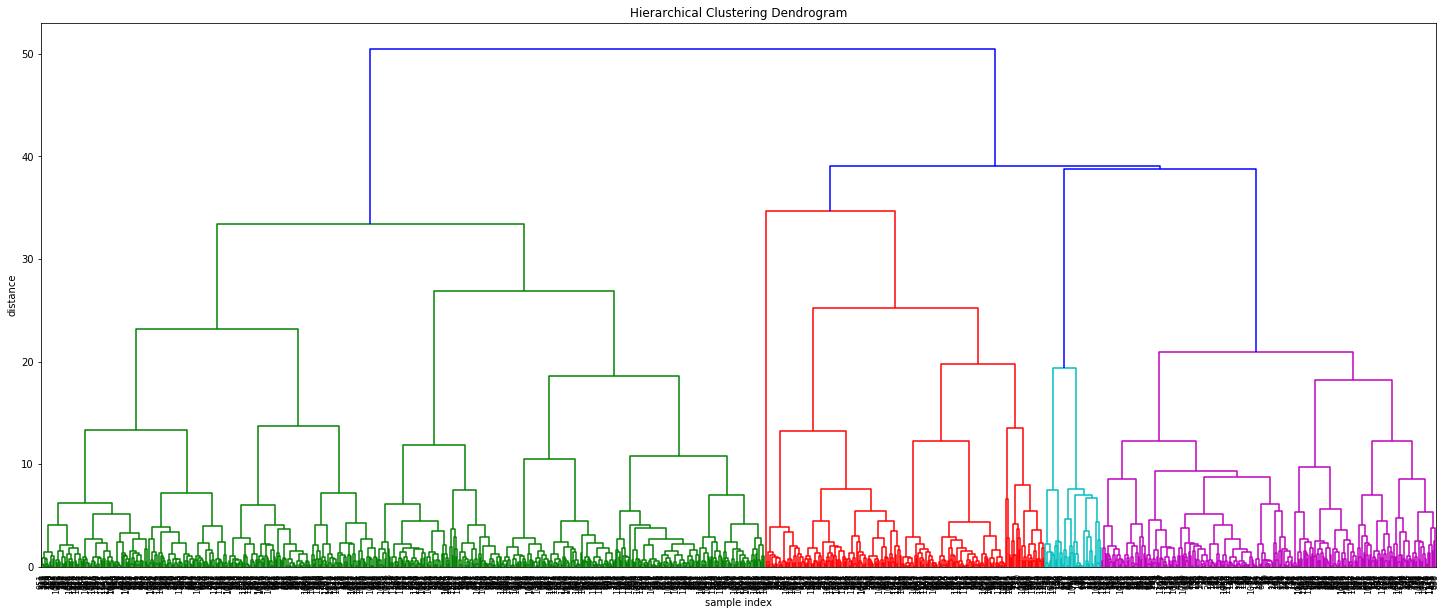

array([ 34.6503 ,  38.73609,  39.03209,  50.49938])

In [16]:
# calculate full dendrogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()


Z[-4:,2]

In [17]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

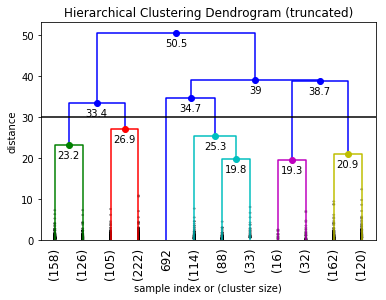

In [18]:
fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,          # useful in small plots so annotations don't overlap
    max_d=30,  # plot a horizontal cut-off line; max_d = max_distance
)
plt.show()

### K Means Clustering

In [19]:
from sklearn.cluster import KMeans

In [20]:
kmeans2 = KMeans(n_clusters=2)
kmeans2.fit_transform(X)
kmeans2.predict(X)
kmeans2.labels_

array([0, 0, 0, ..., 1, 1, 0])

In [21]:
kmeans3 = KMeans(n_clusters=3)
kmeans3.fit_transform(X)
kmeans3.predict(X)
kmeans3.labels_

array([1, 1, 1, ..., 0, 0, 2])

In [22]:
kmeans4 = KMeans(n_clusters=4)
kmeans4.fit_transform(X)
kmeans4.predict(X)
kmeans4.labels_

array([3, 3, 3, ..., 1, 1, 0])

In [23]:
kmeans5 = KMeans(n_clusters=5)
kmeans5.fit_transform(X)
kmeans5.predict(X)
kmeans5.labels_

array([3, 3, 3, ..., 2, 2, 0])

In [24]:
kmeans6 = KMeans(n_clusters=6)
kmeans6.fit_transform(X)
kmeans6.predict(X)
kmeans6.labels_

array([2, 2, 2, ..., 4, 0, 1])

### Look at Jaccard similarity score

In [25]:
from sklearn.metrics import jaccard_similarity_score

## In binary and multiclass classification, this function is equivalent to the accuracy_score.
## It differs in the multilabel classification problem.

In [26]:
jaccard_similarity_score(dfsample1['IS_HID'], kmeans2.labels_)

0.3143585386576041

In [27]:
jaccard_similarity_score(dfsample1['IS_HID'], kmeans3.labels_)

0.53016142735768901

In [28]:
jaccard_similarity_score(dfsample1['IS_HID'], kmeans4.labels_)

0.34324553950722175

In [29]:
jaccard_similarity_score(dfsample1['IS_HID'], kmeans5.labels_)

0.20050977060322855

In [30]:
jaccard_similarity_score(dfsample1['IS_HID'], kmeans6.labels_)

0.20135938827527614

In [31]:
X_unscaled['Prediction'] = kmeans2.labels_

In [32]:
X_unscaled['Actual'] = dfsample1['IS_HID']

In [33]:
X_unscaled.head()

,Hospital_Associated_encoded,Tot_Sls_Amt,Msa_Dma_encoded,Salesperson_encoded,ST_encoded,Chain_Name_encoded,LMS_Available_Matching_Funds,Prediction,Actual
Account,,,,,,,,,
410092,3,988589.0,139,10,28,38,0.0,0,1
363318,0,132586.0,85,31,16,33,5800.0,0,1
304550,0,412451.0,145,110,48,38,1200.0,0,1
756418,3,421148.0,153,10,28,39,700.0,0,1
410068,3,624629.0,139,10,28,38,0.0,0,1


In [34]:
X_unscaled.to_csv('data/HID_clustering_undersampled_predictions.csv')

In [35]:
y = df_clean['IS_HID']

In [36]:
Xc = df_clean[['Hospital_Associated_encoded', 'Tot_Sls_Amt', 'Msa_Dma_encoded',
                'Salesperson_encoded', 'ST_encoded',
                'Chain_Name_encoded','LMS_Available_Matching_Funds']]

In [37]:
df_clean_reduced['Predicted_HID'] = kmeans2.predict(df_clean_reduced)

C:\ProgramData\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [38]:
df_clean_reduced['Actual_HID'] = df_clean['IS_HID']

C:\ProgramData\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [39]:
df_clean_reduced.head()

,Hospital_Associated_encoded,Tot_Sls_Amt,Msa_Dma_encoded,Salesperson_encoded,ST_encoded,Chain_Name_encoded,LMS_Available_Matching_Funds,Predicted_HID,Actual_HID
Account,,,,,,,,,
10491,15,141319.0,183,1,37,39,822.0,1,0
17475,15,211381.0,190,1,37,39,0.0,1,0
19901,15,151490.0,183,1,37,39,0.0,1,0
309745,15,165231.0,183,1,37,39,0.0,1,0
652229,15,129169.0,183,1,37,38,340.0,1,0


In [40]:
kmeans2_score_acc = np.mean(cross_val_score(kmeans2, Xc, y, cv=5))
kmeans2_score_recall = recall_score(y, kmeans2.predict(Xc), average='weighted') 
kmeans2_score_avgprecision = average_precision_score(y, kmeans2.predict(Xc))
print(kmeans2_score_acc, kmeans2_score_recall, kmeans2_score_avgprecision)

-3.94083162228e+13 0.0724308708213 0.0364974821772


### Clustering with only top 2 Features

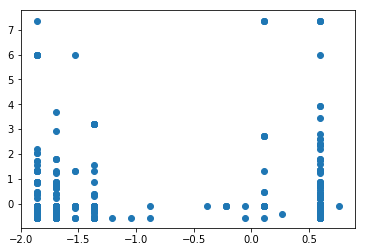

In [41]:
plt.scatter(X['Hospital_Associated_encoded'],X['LMS_Available_Matching_Funds'] )

plt.show()

In [42]:
X = df_clean_reduced[['Hospital_Associated_encoded', 'LMS_Available_Matching_Funds']]

### K Means with only top 2 Features

In [43]:
kmeans2feat = KMeans(n_clusters=2)
kmeans2feat.fit_transform(X)
kmeans2feat.predict(X)
kmeans2feat.labels_

array([0, 0, 0, ..., 0, 0, 0])

In [44]:
jaccard_similarity_score(df_clean['IS_HID'], kmeans2feat.labels_)

0.93210895583986797

In [45]:
df_clean_reduced['Predicted-2Feat-HID'] = kmeans2feat.labels_

C:\ProgramData\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [46]:
df_clean_reduced.head()

,Hospital_Associated_encoded,Tot_Sls_Amt,Msa_Dma_encoded,Salesperson_encoded,ST_encoded,Chain_Name_encoded,LMS_Available_Matching_Funds,Predicted_HID,Actual_HID,Predicted-2Feat-HID
Account,,,,,,,,,,
10491,15,141319.0,183,1,37,39,822.0,1,0,0
17475,15,211381.0,190,1,37,39,0.0,1,0,0
19901,15,151490.0,183,1,37,39,0.0,1,0,0
309745,15,165231.0,183,1,37,39,0.0,1,0,0
652229,15,129169.0,183,1,37,38,340.0,1,0,0


In [54]:
Xd = Xc[['Hospital_Associated_encoded', 'LMS_Available_Matching_Funds']]

In [56]:
kmeans2feat_score_acc = np.mean(cross_val_score(kmeans2feat, Xd, y, cv=5))
kmeans2feat_score_recall = recall_score(y, kmeans2feat.predict(Xd), average='weighted') 
kmeans2feat_score_avgprecision = average_precision_score(y, kmeans2feat.predict(Xd))
print(kmeans2feat_score_acc, kmeans2feat_score_recall, kmeans2feat_score_avgprecision)

-1463662683.51 0.93210895584 0.0509467814037


In [47]:
df_clean_reduced.to_csv('data/HID_clustering_all_obs_predictions.csv')

### Mean Shift

In [48]:
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.datasets.samples_generator import make_blobs

# Mean shift clustering aims to discover “blobs” in a smooth density of samples. 
# It is a centroid-based algorithm, which works by updating candidates for centroids to be the mean 
# of the points within a given region. These candidates are then filtered in a post-processing stage 
# to eliminate near-duplicates to form the final set of centroids.

In [49]:
bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=500)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

ms_labels_unique = np.unique(labels)
n_clusters_ = len(ms_labels_unique)

print("number of estimated clusters : %d" % n_clusters_)

number of estimated clusters : 13


### Affinity Propagation

In [50]:
from sklearn.cluster import AffinityPropagation
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs

In [51]:
#af = AffinityPropagation().fit(X)
#cluster_centers_indices = af.cluster_centers_indices_
#labels = af.labels_
#n_clusters_ = len(cluster_centers_indices)

In [52]:
#n_clusters_